# Connect 4

**Questions**:

Should we put more error checking in our code? We risk slowing things down with more error checking. Maybe we should only have error checking for human play.

Why is MCTS not working? Is the backprop function not right? Maybe try reversing the numbers in backprop. Try playing MCTS against MCTS.

---

**Overview of MCTS**

MCTS balances betwen exploring possible moves and exploting successful moves. It's useful for Connect 4 because there are more states than can be explored due to computational limits.

Components:
- Tree traversal and node expansion
    - Determine the possible plays for various board states
- Rollout
    - Random simulation of a game that is used to determine the next best move when you reach a node (board state) that you haven't yet exploited (tried playing)
- Backpropagation
    - Retrace your path to the root node, updating the win rate for each node

Steps:
- Start at root node (empty board or provided board)
- Check if the current node is a leaf node (win/lose/tie state)
   - If a node is identified as a leaf node but it's not a win/lose/tie state, the current node may not have child nodes added yet.
       - If the node hasn't had a simulation yet, run a simulation to determine the selection value (UCBI/UCT)
       - If the node has already had a simulation, add each available action from the current node as a new state to the tree
    - If a node is not identified as a leaf node, select one of the child nodes of current that maximizes the selection value (child nodes that haven't yet been explored will have higher selection values)

**Upper Confidence Bound for Trees (UCT)** formula used to pick move:
$$UCT = \frac{W_i}{N_i} + C \sqrt{\frac{\ln{N_p}}{N_i}} $$
- $W_i$: Total wins for the child node *i*.
- $N_i$: Total simulations for the child node *i*.
- $N_p$: Total simulations for the parent node
- $C$: exploitation paramter, balancing exploration and exploitation
- Exploitation (left term) and exploration (right term) are balanced
    - MCTS will initially favor exploration over exploitation because child nodes that haven't been explored will have infinitely large UCT values (denominator $N_i = 0$)
- Traverse the tree by selecting the child node with the highest UCT value until a leaf node is reached.
    - If the child nodes or other nodes along the path don't have UCT values, then they will be randomly chosen until a terminal node is reached (win/loss/tie)


To learn more about MCTS, here are a few links that informed my notes:
- [Visual Demonstration of MCTS on YouTube](https://www.youtube.com/watch?v=UXW2yZndl7U)
- [Connect 4 Project Using MCTS](https://mcts.netlify.app/mcts/)
- [Alternative Connect 4 Project using MCTS (with code)](https://www.harrycodes.com/blog/monte-carlo-tree-search)

In [21]:
import numpy as np
from IPython.display import clear_output
import time
import random
import copy
import pandas as pd
from tqdm import tqdm
# https://www.youtube.com/watch?v=UXW2yZndl7U

# Functions for Play

In [22]:
# Using 2x6x7 representation
def update_board(board_temp,color,column):
    """
    Update the game board by placing a checker in the specified column.

    This function takes the current board status, the player's checker color,
    and the column in which they want to place the checker, then updates the board accordingly.
    If the column is full, the current board is returned unchanged.

    Args:
        board_temp (numpy.ndarray): A 2x6x7 representation of the game board.
            The first layer corresponds to one player, and the second layer to the other.
            Values are 0 (empty) or 1 (occupied).
        color (str): The color of the checker, either 'red' or 'yellow'.
            'red' corresponds to the first layer (index 0), and 'yellow' to the second layer (index 1).
        column (int): The column (0 through 6) where the checker should be placed.
            If the column is full, the board remains unchanged.

    Returns:
        numpy.ndarray: The updated board after placing the checker.
        If the column is full, the original board is returned.

    Notes:
        - The board is copied before making modifications, ensuring the original input remains unchanged.
        - The function assumes valid inputs, but the player is responsible for avoiding full columns.
    """
    board = board_temp.copy()
    ncol = board.shape[1]
    nrow = board.shape[0]

    # this seems silly, but actually faster to run than using sum because of overhead!
    # colsum = sum(board[0, row, column] + board[1, row, column] for row in range(nrow))
    colsum = board[0,column,0]+board[1,column,0]+ board[2,column,0] + board[3,column,0] + board[4,column,0] + board[5,column,0] + board[0,column,1] + board[1,column,1] + board[2,column,1] + board[3,column,1] + board[4, column,1] + board[5, column,1]
    # no need to do abs() now because both boards are filled in with either 0s or 1s (no more -1s now that we have one "board" per opponent)

    # Check if the selected column is full (might slow down runtime, only necessary for human play)
    if colsum == nrow:
        raise ValueError(f"Column {column} is full. Please select a different column.")

    row = int(5-colsum) # returns index 0 - 5
    if row > -0.5:
      # i.e. as long as we have a slot available
        if color == 'red':
            board[row,column,0] = 1
        else:
            board[row,column,1] = 1
    return board

In [23]:
def check_for_win(board,col):
    """
    Check for a winning condition in the game after a move in the specified column.

    This function evaluates the board to determine if the most recent move in the specified
    column resulted in a win. It checks for four consecutive checkers of the same color
    in vertical, horizontal, and diagonal directions.

    Args:
        board (numpy.ndarray): A 2x6x7 representation of the game board.
            The first layer corresponds to the 'red' player's pieces, and the second layer to 'yellow'.
            Each layer contains 0s (empty) or 1s (occupied).
        col (int): The column (0 through 6) where the move was made.

    Returns:
        str: A string indicating the result of the check:
            - 'v-red': Vertical win for the 'red' player.
            - 'v-yellow': Vertical win for the 'yellow' player.
            - 'h-red': Horizontal win for the 'red' player.
            - 'h-yellow': Horizontal win for the 'yellow' player.
            - 'd-red': Diagonal win for the 'red' player (bottom-left to top-right).
            - 'd-yellow': Diagonal win for the 'yellow' player (bottom-left to top-right).
            - 'nobody': No winning condition is detected.

    Notes:
        - Assumes that the move in the given column was valid (i.e., the column was not full).
        - The function checks for wins starting from the position of the most recent move.
        - Diagonal checks include both bottom-left-to-top-right and top-left-to-bottom-right directions.
        - THIS DOESN'T ACCOUNT FOR TIES RIGHT NOW! NEED TO FIX THIS FOR REAL PLAY!
    """
    nrow = 6
    ncol = 7
    # take advantage of knowing what column was last played in...need to check way fewer possibilities
    board = board[:,:,0] - board[:,:,1] # create same board as what Dan used (6x7 with +1 for 'red' and -1 for 'yellow')
    colsum = abs(board[0,col])+abs(board[1,col])+abs(board[2,col])+abs(board[3,col])+abs(board[4,col])+abs(board[5,col])
    row = int(6-colsum)
    if row+3<6:
        vert = board[row,col] + board[row+1,col] + board[row+2,col] + board[row+3,col]
        if vert == 4:
            return 'v-red'
        elif vert == -4:
            return 'v-yellow'
    if col+3<7:
        hor = board[row,col] + board[row,col+1] + board[row,col+2] + board[row,col+3]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if col-1>=0 and col+2<7:
        hor = board[row,col-1] + board[row,col] + board[row,col+1] + board[row,col+2]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if col-2>=0 and col+1<7:
        hor = board[row,col-2] + board[row,col-1] + board[row,col] + board[row,col+1]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if col-3>=0:
        hor = board[row,col-3] + board[row,col-2] + board[row,col-1] + board[row,col]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if row < 3 and col < 4:
        DR = board[row,col] + board[row+1,col+1] + board[row+2,col+2] + board[row+3,col+3]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row-1>=0 and col-1>=0 and row+2<6 and col+2<7:
        DR = board[row-1,col-1] + board[row,col] + board[row+1,col+1] + board[row+2,col+2]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row-2>=0 and col-2>=0 and row+1<6 and col+1<7:
        DR = board[row-2,col-2] + board[row-1,col-1] + board[row,col] + board[row+1,col+1]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row-3>=0 and col-3>=0:
        DR = board[row-3,col-3] + board[row-2,col-2] + board[row-1,col-1] + board[row,col]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row+3<6 and col-3>=0:
        DL = board[row,col] + board[row+1,col-1] + board[row+2,col-2] + board[row+3,col-3]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    if row-1 >= 0 and col+1 < 7 and row+2<6 and col-2>=0:
        DL = board[row-1,col+1] + board[row,col] + board[row+1,col-1] + board[row+2,col-2]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    if row-2 >=0 and col+2<7 and row+1<6 and col-1>=0:
        DL = board[row-2,col+2] + board[row-1,col+1] + board[row,col] + board[row+1,col-1]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    if row-3>=0 and col+3<7:
        DL = board[row-3,col+3] + board[row-2,col+2] + board[row-1,col+1] + board[row,col]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    return 'nobody'

In [24]:
# testing update board and check for win
# if actually playing game, make sure to use (user input - 1) for the col so it matches index
board = np.zeros((6,7,2))
board = update_board(board,'red',6)
board = update_board(board,'yellow',1)
board = update_board(board,'red',2)
board = update_board(board,'yellow',2)
board = update_board(board,'red',3)
board = update_board(board,'yellow',3)
board = update_board(board,'red',4)
board = update_board(board,'yellow',3)
board = update_board(board,'red',4)
board = update_board(board,'yellow',4)
board = update_board(board,'red',3)
board = update_board(board,'yellow',4)
check_for_win(board, 4)
# print(board)

'd-yellow'

In [25]:
def find_legal(board):
    board = board[:,:,0] + board[:,:,1]
    # Identify columns that aren't full
    legal = [i for i in range(7) if board[0,i] == 0]
    return legal

In [26]:
def look_for_win(board_,color):
    board_ = board_.copy()
    legal = find_legal(board_)
    winner = -1
    for m in legal:
        bt = update_board(board_.copy(),color,m)
        wi = check_for_win(bt,m)
        if wi[2:] == color:
          # only checking the last part of the string that check_for_win returns; e.g. 'd-yellow' becomes 'yellow'
            winner = m
            break
    return winner

In [27]:
def find_all_nonlosers(board,color):
    '''
    Determines all of the next moves that won't lead to your opponent winning.
    If your opponet has 1 move until 4 in a row, then the only mose returned will be the move that blocks 4 in a row.
    If your opponent has multiple moves where they could get 4 in a row in the next turn, then you any move that blocks
    at least one of the 4 in a rows will be recommended. You'll lose, but at least you will have tried to block it.
    If you opponent has no moves that win on the next turn, 
    '''
    if color == 'red':
        opp = 'yellow'
    else:
        opp = 'red'
    legal = find_legal(board)
    poss_boards = [update_board(board,color,l) for l in legal]
    poss_legal = [find_legal(b) for b in poss_boards]
    # we do the second find_legal() to check that we aren't accidentally giving our opponent a win. just because the current team plays a legal move,
    # still leaves the possibility that the opponent's next move will win them the game
    allowed = []
    for i in range(len(legal)):
        wins = [j for j in poss_legal[i] if check_for_win(update_board(poss_boards[i],opp,j),j) != 'nobody']
        # alternative way to check if check_for_win return any winners; add the column when check_for_win returns anything but 'nobody'
        if len(wins) == 0:
            allowed.append(legal[i])
    return allowed

In [28]:
def back_prop(winner,path,color0,md):
    '''
    Updates the tree being developed by Monte Carlo tree search with the results of one simulated game.
    Moves that lead to the current player winning will be played more in the future based on this updated tree,
    whereas moves that lead to the current player losing will be played less in the future.
    '''
  # goal is count the number of times a node in the tree is visited (md[board_temp][0]) as well as keep track of the "reward"
  # for the initiating player at each node

    for i in range(len(path)):
        board_temp = path[i]

        md[board_temp][0]+=1
        # md is a dictionary

        if winner[2]==color0[0]:
          # in this scenario, the initiating player (color0) won the game
            if i % 2 == 1: # opponent's move
            # if an opponent's move led to color0 winning, that increases color0's reward at that node
                md[board_temp][1] += 1

            else:
                md[board_temp][1] -= 1
            # decrease the reward to reflect a missed opportunity; color0 did not win on its turn. it won down the road, but this helps us find the true
            # optimal strategy rather than strategies that will ~eventually~ lead to a win

        elif winner[2]=='e': # tie
            # md[board_temp][1] += 0
            pass
        else:
            if i % 2 == 1: # opponent's move
                md[board_temp][1] -= 1
            else:
                md[board_temp][1] += 1
                # i'm not sure why this last line is like this... isn't this rewarding the initiating player for the opponent winning after their move?

In [29]:
def rollout(board,next_player):
    '''
    Simulates games within MCTS to select the best move.
    '''
    winner = 'nobody'
    player = next_player
    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            winner = 'tie'
            return winner
        move = random.choice(legal)
        board = update_board(board,player,move)
        winner = check_for_win(board,move)

        if player == 'red':
            player = 'yellow'
        else:
            player = 'red'
    return winner

In [9]:
def better_rollout(board, next_player):
    """
    Will look for a winning move first. If that doesn't exist, will play a move that doesn't lead to opponent immediately winning.
    If that doesn't exist, will play a random legal move.
    """
    winner = 'nobody'
    player = next_player
    while winner == 'nobody':

        legal = find_legal(board)
        if len(legal) == 0:
            winner = 'tie'
            return winner
        winColumn = look_for_win(board,player) # check to find a winning column
        if winColumn > -0.5:
            move = winColumn # if there is one - play that!
        else:
            legal = find_all_nonlosers(board,player) # find all moves that won't immediately lead to your opponent winning
            if len(legal) == 0: # if you can't block your opponent - just find the 'best' losing move
                legal = find_legal(board)
            move = random.choice(legal)
        board = update_board(board,player,move)
        winner = check_for_win(board,move)

        if player == 'red':
            player = 'yellow'
        else:
            player = 'red'
    return winner

In [30]:
def mcts(board_temp,color0,nsteps):
    # nsteps is a parameter that determines the skill (and slowness) of the player
    # bigger values of nsteps means the player is better, but also slower to figure out a move.
    board = board_temp.copy()
    ##############################################
    winColumn = look_for_win(board,color0) # check to find a winning column
    if winColumn > -0.5:
        return winColumn # if there is one - play that!
    legal0 = find_all_nonlosers(board,color0) # find all moves that won't immediately lead to your opponent winning
    if len(legal0) == 0: # if you can't block your opponent - just find the 'best' losing move
        legal0 = find_legal(board)
    ##############################################
    # the code above, in between the hash rows, is not part of traditional MCTS
    # but it makes it better and faster - so I included it!
    # MCTS occasionally makes stupid mistakes
    # like not dropping the checker on a winning column, or not blocking an obvious opponent win
    # this avoids a little bit of that stupidity!
    # we could also add this logic to the rest of the MCTS and rollout functions - I just haven't done that yet...
    # feel free to experiment!
    mcts_dict = {tuple(board.ravel()):[0,0]}
    for ijk in range(nsteps):
        color = color0
        winner = 'nobody'
        board_mcts = board.copy()
        path = [tuple(board_mcts.ravel())]
        # play until someone wins or there is a tie
        while winner == 'nobody':
            legal = find_legal(board_mcts)
            if len(legal) == 0:
                winner = 'tie'
                back_prop(winner,path,color0,mcts_dict)
                break
            board_list = []
            for col in legal:
                board_list.append(tuple(update_board(board_mcts,color,col).ravel()))
            for bl in board_list:
                if bl not in mcts_dict.keys():
                    mcts_dict[bl] = [0,0]
            ucb1 = np.zeros(len(legal))
            for i in range(len(legal)):
                num_denom = mcts_dict[board_list[i]]
                if num_denom[0] == 0:
                    ucb1[i] = 10*nsteps
                else:
                    ucb1[i] = num_denom[1]/num_denom[0] + 2*np.sqrt(np.log(mcts_dict[path[-1]][0])/mcts_dict[board_list[i]][0])
            chosen = np.argmax(ucb1)

            board_mcts = update_board(board_mcts,color,legal[chosen])
            path.append(tuple(board_mcts.ravel()))
            winner = check_for_win(board_mcts,legal[chosen])
            if winner[2]==color[0]:
                back_prop(winner,path,color0,mcts_dict)
                break
            if color == 'red':
                color = 'yellow'
            else:
                color = 'red'
            if mcts_dict[tuple(board_mcts.ravel())][0] == 0:
                winner = rollout(board_mcts,color)
                back_prop(winner,path,color0,mcts_dict)
                break

    maxval = -np.inf
    best_col = -1
    for col in legal0:
        board_temp = tuple(update_board(board,color0,col).ravel())
        num_denom = mcts_dict[board_temp]
        if num_denom[0] == 0:
            compare = -np.inf
        else:
            compare = num_denom[1] / num_denom[0]
        if compare > maxval:
            maxval = compare
            best_col = col
    return (best_col)

In [11]:
def better_mcts(board_temp,color0,nsteps):
    """
    This version of MCTS uses the better rollout function that guarantees each player will play a winning move or block
    before choosing a random move.
    """
    # nsteps is a parameter that determines the skill (and slowness) of the player
    # bigger values of nsteps means the player is better, but also slower to figure out a move.
    board = board_temp.copy()
    ##############################################
    winColumn = look_for_win(board,color0) # check to find a winning column
    if winColumn > -0.5:
        return winColumn # if there is one - play that!
    legal0 = find_all_nonlosers(board,color0) # find all moves that won't immediately lead to your opponent winning
    if len(legal0) == 0: # if you can't block your opponent - just find the 'best' losing move
        legal0 = find_legal(board)
    ##############################################
    # the code above, in between the hash rows, is not part of traditional MCTS
    # but it makes it better and faster - so I included it!
    # MCTS occasionally makes stupid mistakes
    # like not dropping the checker on a winning column, or not blocking an obvious opponent win
    # this avoids a little bit of that stupidity!
    # we could also add this logic to the rest of the MCTS and rollout functions - I just haven't done that yet...
    # feel free to experiment!
    mcts_dict = {tuple(board.ravel()):[0,0]}
    for ijk in range(nsteps):
        color = color0
        winner = 'nobody'
        board_mcts = board.copy()
        path = [tuple(board_mcts.ravel())]
        # plya until someone wins or there is a tie
        while winner == 'nobody':
            legal = find_legal(board_mcts)
            if len(legal) == 0:
                winner = 'tie'
                back_prop(winner,path,color0,mcts_dict)
                break
            board_list = []
            for col in legal:
                board_list.append(tuple(update_board(board_mcts,color,col).ravel()))
            for bl in board_list:
                if bl not in mcts_dict.keys():
                    mcts_dict[bl] = [0,0]
            ucb1 = np.zeros(len(legal))
            for i in range(len(legal)):
                num_denom = mcts_dict[board_list[i]]
                if num_denom[0] == 0:
                    ucb1[i] = 10*nsteps
                else:
                    ucb1[i] = num_denom[1]/num_denom[0] + 2*np.sqrt(np.log(mcts_dict[path[-1]][0])/mcts_dict[board_list[i]][0])
            chosen = np.argmax(ucb1)

            board_mcts = update_board(board_mcts,color,legal[chosen])
            path.append(tuple(board_mcts.ravel()))
            winner = check_for_win(board_mcts,legal[chosen])
            if winner[2]==color[0]:
                back_prop(winner,path,color0,mcts_dict)
                break
            if color == 'red':
                color = 'yellow'
            else:
                color = 'red'
            if mcts_dict[tuple(board_mcts.ravel())][0] == 0:
                winner = better_rollout(board_mcts,color)
                back_prop(winner,path,color0,mcts_dict)
                break

    maxval = -np.inf
    best_col = -1
    for col in legal0:
        board_temp = tuple(update_board(board,color0,col).ravel())
        num_denom = mcts_dict[board_temp]
        if num_denom[0] == 0:
            compare = -np.inf
        else:
            compare = num_denom[1] / num_denom[0]
        if compare > maxval:
            maxval = compare
            best_col = col
    return (best_col)

# Building Datasets
Potential classifications for MCTS:
- Beginner: 100-500 steps
- Intermediate: 500-2000 steps
- Expert: 2000-1000+

If we want to create more data, updated code to do so using MCTS 7000.

In [12]:
# Store moves for both players
# A random # of random starting moves (not stored)
sim_games = []
who_won = []
moves_per_game = []  # Record the number of moves per game
game = 0
# Use tqdm for a progress bar
for i in tqdm(range(3000), desc="Simulating Games", unit="game"):
    board = np.zeros((2,6,7))  # Reset board
    winner = 'nobody'  # Reset winner
    color = 'red' # Red always plays first
    # choose a number of random moves to play from 0-15
    n_random = random.choice(np.arange(0,16))
    for i in range(n_random):
        m = random.choice(find_legal(board))
        if i % 2:
            color = 'red'
            board = update_board(board, color, m)
        else:
            color = 'yellow'
            board = update_board(board, color, m)
    
    # Switch color after playing random moves
    if color == 'red':
        color = 'yellow'
    else:
        color = 'red'
    
    moves = 0  # Reset move count
    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            winner = 'tie'
            break

        if color == 'yellow':
            col = mcts(board, color, 7000)
            sim_games.append((tuple(board.ravel()), col, 'yellow', 1500, 1500, game, n_random))
        
        else:
            col = mcts(board, color, 7000)
            sim_games.append((tuple(board.ravel()), col, 'red', 1500, 1500, game, n_random))

        # Update board
        board = update_board(board, color, col)
        moves += 1 # record moves

        # Check for win
        winner = check_for_win(board, col)

        # Switch player
        color = 'yellow' if color == 'red' else 'red'

    # Record game result
    moves_per_game.append(moves)
    who_won.append(winner)
    game += 1

Simulating Games: 100%|█████████████████| 3000/3000 [8:50:27<00:00, 10.61s/game]


In [ ]:
# MAKE SURE THIS WORKS!!

# Preprocessing: convert tuple to array
df['x'] = df['x'].reshape((6,7,2)) # save as 6x7x2 array

# Switch player
# change perspective for yellow to be the same as red (switch the first index or switch the last index once we fix shape)
def switch_players(df):
    if df['whose_turn'] != 'red':
        # Flip the layers to make each board look like it's from the perspective of "red", aka plus
        df['x'] = df['x'][:, :, ::-1]
    return df
df = df.apply(switch_players, axis=1)

# Double size of dataset by fliupping boards
def flip_board(board, col):
    new_board = np.flip(board, axis = 1) # axis 1 = columns
    new_column = 6 - col
    return new_board, new_column
flipped_x = []
flipped_y = []
for index, row in df.iterrows():
    board = row['x']
    col = row['y']
    new_board, new_column = flip_board(board, col)
    flipped_x.append(new_board)
    flipped_y.append(new_column)
new_df = pd.DataFrame({"x": flipped_x, "y": flipped_y})

# Insert matching previous columns
new_df = pd.concat([new_df, df.loc[:, 'whose_turn':'who_won']], axis=1)
new_df['game'] += 15000

# Append the df of flipped boards
df = pd.concat([df, new_df], ignore_index = True)

# Create tuple again
df['x_tuple'] = df['x'].apply(lambda x:tuple(x.ravel())) # save tuple for later use in exploration (couldn't use arrays)

In [ ]:
# Do additional preprocessing?

# Check duplicate games and variety of moves


In [13]:
# Save simulated games
df = pd.DataFrame(sim_games, columns=["x", "y", "whose_turn", "opponent_level", "player_level", "game", "random_moves"])
game_info = pd.DataFrame({'moves_per_game':moves_per_game, 'who_won':who_won}).reset_index().rename(columns={'index':'game'})
df = df.merge(game_info, on='game')
df.to_pickle("data/MCTS7000_6-7-2shape_cleaned.pkl")

# Playing
I'll have MCTS play a person so that we can try displaying this on Anvil while we work on other code.

In [33]:
# alternative plotting function (looks nicer)
import numpy as np
import matplotlib.pyplot as plt

def plot_connect4(board, ax=None):
    """
    Plots a Connect 4 board using Matplotlib.

    Parameters:
        board (3D numpy array): A 2x6x7 matrix representing the board state.
                                Player 1 is the first 6x7 board and Player 2 is the 2nd 6x7 board.
                                0 for empty, 1 for occupied board space.
        ax (matplotlib.axes): Matplotlib Axes object to plot on (optional).
    """
    rows, cols = board[:,:,0].shape
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))

    # Plot grid
    for row in range(rows):
        for col in range(cols):
            color = "white"  # Default empty color
            if board[row, col,0] == 1:
                color = "red"  # Player 1's pieces
            elif board[row, col,1] == 1:
                color = "yellow"  # Player 2's pieces

            # Draw a circle for each slot
            circle = plt.Circle((col + 0.5, rows - row - 0.5), 0.4, color=color, ec="black", lw=1)
            ax.add_patch(circle)

    # Configure axis
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_xticks(np.arange(cols) + 0.5, labels=np.arange(1, cols + 1))
    ax.set_yticks(np.arange(rows) + 0.5, labels=np.arange(rows, 0, -1))
    ax.grid(False)
    ax.set_aspect('equal')
    ax.set_facecolor("blue")  # Board background color
    ax.tick_params(left=False, bottom=False, labelsize=12)

    plt.show()

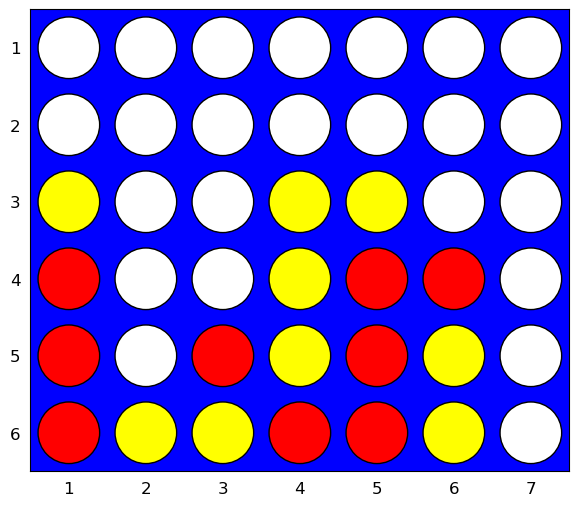

KeyboardInterrupt: Interrupted by user

In [35]:
###### this is how you can play a game
winner = 'nobody'
board = np.zeros((6,7,2))
plot_connect4(board)
player = 'red'

human_player = input('Which player would you like to be? Red or yellow? Red goes first.')
if human_player == 'red':
  bot_player = 'yellow'
else:
  bot_player = 'red'

while winner == 'nobody':
    if player == human_player:
        move = input('Pick a move (1-7) for player '+player+': ')
        move = int(move) - 1
        board = update_board(board,player,move)
        clear_output()
        plot_connect4(board)
        winner = check_for_win(board,move)
    elif player != human_player:
        print('Bot is thinking...')
        move = mcts(board, player, 100)
        board = update_board(board,player,move)
        clear_output()
        plot_connect4(board)
        winner = check_for_win(board,move)
    if player == 'red':
        player = 'yellow'
    else:
        player = 'red'

print('The winner is '+winner)